<a href="https://colab.research.google.com/github/DCI-alxogm/ml2023-BlackPuma075/blob/main/Nov_3_4/Proyecto_Parcial_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

Los datos son una colección de la anomalía en la temperatura global en comparación con la temperatura global promedio de 1951 a 1980.\
Los datos fueron obtenidos de https://climate.nasa.gov/en-espanol/signos-vitales/temperatura-global/

In [ ]:
NASA = np.loadtxt('/content/drive/MyDrive/Machine_Learning/temperatura global.txt') #Pongo los datos en una variable llamada NASA
X = NASA[:,0] #selecciono la columna de temperatura y defino como x
Y = NASA[:,1] #selecciona la primera columna de los años y defino como y
Y.shape

(143,)

In [ ]:
X = (X-min(X)) #Normalizo los datos del año

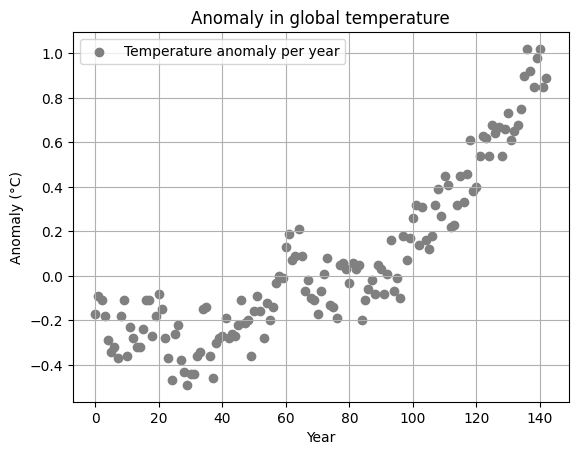

In [ ]:
#Imprimo la dispersión de los datos en una gráfica de año vs la anomalía en la temperatura
plt.scatter(X,Y, color = 'gray', label = 'Temperature anomaly per year')
plt.xlabel('Year')
plt.ylabel('Anomaly (°C)')
plt.title('Anomaly in global temperature')
plt.legend()
plt.grid()

Lo siguiente que haré es un análisis con el método de LS para determinar el modelo y los pesos iniciales

In [ ]:
def w_n(x,y,norder, lmbd, alpha, N): #Minimos cuadrados regularizado para orden n
  x = np.asarray([x])
  X = np.ones_like(x)
  for n in range(1, norder+1):
    X = np.append(X, x**n,axis = 0)
  N = len(x)
  X = X.T
  t = y
  X_tX = np.matmul(X.T,X)
  I = np.ones_like(X_tX)
  X_tXNI = X_tX+(N*lmbd*I)
  invX_tXNI = np.linalg.inv(X_tXNI)
  X_tt = np.matmul(X.T, t)
  w = np.matmul(invX_tXNI,X_tt)
  cost = 0
  f = 0
  f_p = 0
  f_total = 0
  for i in range(len(w)):
    f += w[i]*x**(i)
  for i in range(1,len(w)):
    f_p += (i-1)*w[i]*x**(i-1)
  f_total = f+alpha*f_p
  cost = ((y-f_total)**2)/(2*len(x))
  cost = cost.sum()
  return w,cost

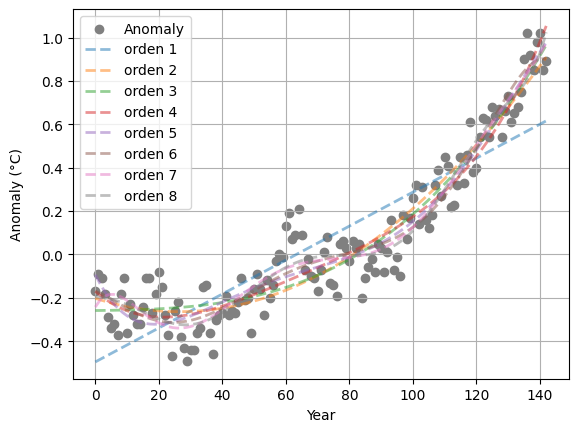

In [ ]:
#Imprimo modelos que se ajustan a los datos hasta orden 8 para elegir el
#que mejor se ajusta
N = 0
norder = 8
lmbd = 0
alpha = 0
x_test = np.linspace(min(X), max(X), 100)
plt.scatter(X,Y, color = 'gray', label = 'Anomaly')
for n in range(1, norder+1):
  w_test,cost = w_n(X,Y,n,lmbd, alpha, N)
  f_test = 0
  for i in range(len(w_test)):
    f_test += w_test[i]*x_test**i
  plt.plot(x_test, f_test, '--', linewidth = 2, label = f'orden {i}', alpha = 0.5)
plt.legend()
plt.xlabel('Year')
plt.ylabel('Anomaly (°C)')
plt.grid()

Text(0.5, 1.0, 'Gráfica de orden vs costo (regularizado, alfa = 0.01)')

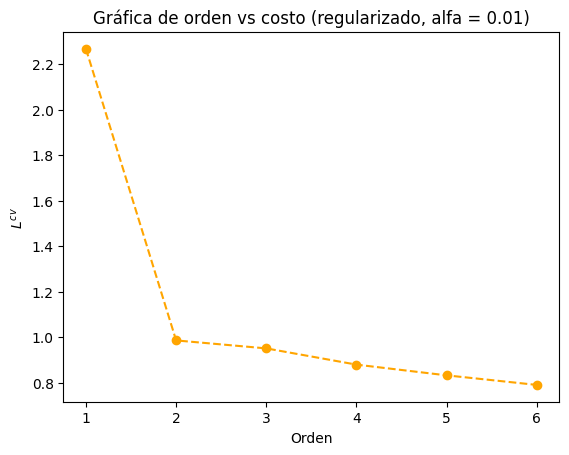

In [ ]:
#Haré el análisis de los costos hasta orden 6, debido a que orden >6 parecían
#estar sobre ajustados
norder = 6
N = len(X)
lmbd = 0.1
norder_l = [1,2,3,4,5,6]
x_test = np.linspace(min(X), max(X), 100)
f_cost = np.ones_like(norder_l, dtype = float)
costos = np.zeros(norder)
for i in range(len(X)):
  x_l = np.concatenate((X[0:i],X[i+1:]))
  y_l = np.concatenate((Y[0:i],Y[i+1:]))
  for n in range(1, norder+1):
    w_test,cost = w_n(X,Y,n, lmbd, 0.01, N)
    f_cost[n-1] = cost
    costos[n-1] += f_cost[n-1]
costos_prom = costos/len(X)
costos_prom

plt.plot(norder_l, costos_prom, '--o', color = 'orange')
plt.xlabel('Orden')
plt.ylabel('$L^{cv}$')
plt.title('Gráfica de orden vs costo (regularizado, alfa = 0.01)')

Con este análisis vemos que el orden 6 es el que tiene menor costo, pero graficaré el modelo para analizarlo individualmente

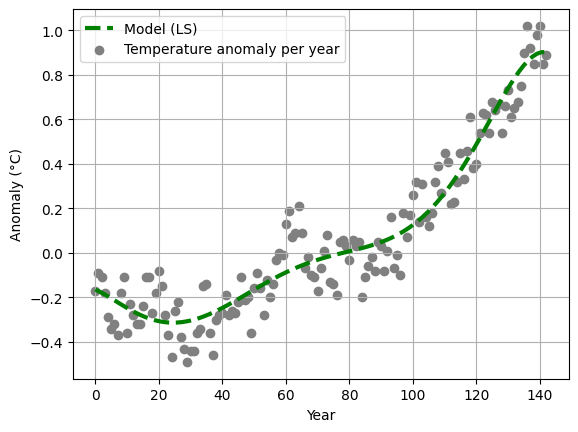

In [ ]:
x0 = np.linspace(min(X), max(X), 100) #Creo un arreglo de datos en el conjunto de X
#Creo una variable para el modelo con los pesos en orden 6 y_p
y_p = w_test[0]+w_test[1]*x0+w_test[2]*x0**2+w_test[3]*x0**3+w_test[4]*x0**4+w_test[5]*x0**5+w_test[6]*x0**6

plt.plot(x0, y_p, 'g--', label = 'Model (LS)', linewidth = 3) #Grafico el modelo (verde)
plt.scatter(X, Y, color = 'gray', label = 'Temperature anomaly per year') #Grafico los datos dispersos (gris)
plt.grid()
plt.legend()
plt.xlabel('Year')
plt.ylabel('Anomaly (°C)')
plt.show()

Procederé a hacer el análisis con ML, con el paquete emcee

In [ ]:
%%capture
!pip install -U setuptools setuptools_scm pep517
!pip install -U emcee
!python -m pip install corner

In [ ]:
f_true = 0.5 #Creo una variable relacionada al modelo analizado con LS
yerr = 0.1 + 0.5 * np.random.rand(len(X)) #Creo un conjunto de datos error en el rango de los datos

In [ ]:
y_psum = sum(y_p)

In [ ]:
w_test #Imprimo los pesos obtenidos en LS para una referencia de peso real

array([-1.64861570e-01, -6.32204695e-03, -4.30070772e-04,  2.81456171e-05,
       -4.98429635e-07,  3.62918673e-09, -9.37131707e-12])

In [ ]:
#Recordando que para hacer el análisis ML por facilidad en el cálculo usamos
#el logaritmo del likelihood, por tanto defino la siguiente función donde ya
#incluyo el modelo que elgí (orden 6)
def log_likelihood(theta, x, y, yerr): #Asigno las variables de entrada de la función
    w0, w1, w2, w3, w4, w5, w6, log_f = theta
    model = w0 + w1*x + w2*x**2 + w3*x**3 + w4*x**4 +w5*x**5+w6*x**6
    sigma2 = yerr**2 + model**2 * np.exp(2 * log_f)
    return -0.5 * np.sum((Y - model) ** 2 / sigma2 + np.log(sigma2))

Maximum likelihood estimates:
w0 = -0.164862
w1 = -0.006322
w2 = -0.000430
w3 = 0.000028
w4 = -0.000000
w5 = 0.000000
w6 = -0.000000
f = 0.50


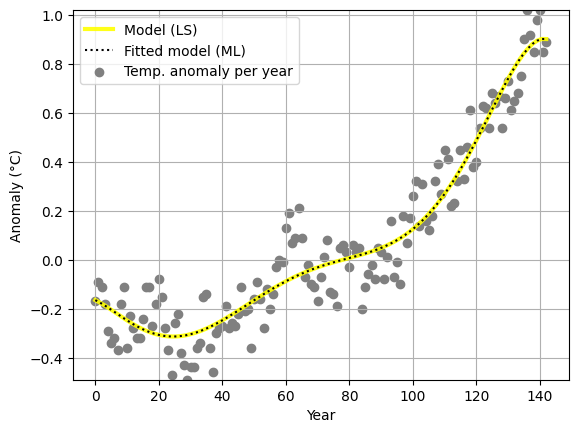

In [ ]:
from scipy.optimize import minimize #importo la paquetería optimize de scipy
#la cual minimiza una función escalar de varias variables

nll = lambda *args: -log_likelihood(*args)
#Creo un arreglo con los valores "verdaderos" obtenidos con LS:
initial = np.array([w_test[0], w_test[1], w_test[2],w_test[3],w_test[4],w_test[5],w_test[6], np.log(f_true)])
#Utilizando la función minimize de scipy minimizamos las variables, dando como entrada
#La función en este caso log_likelihood, y el "initial guess" que en este caso fueron los
#pesos obtenidos por LS:
soln = minimize(nll, initial, args=(X, Y, yerr))
w0ml, w1ml, w2ml, w3ml, w4ml,w5ml,w6ml, log_f_ml = soln.x
#Imprimo los pesos obtenidos por ML:
print("Maximum likelihood estimates:")
print("w0 = {0:.6f}".format(w0ml))
print("w1 = {0:.6f}".format(w1ml))
print("w2 = {0:.6f}".format(w2ml))
print("w3 = {0:.6f}".format(w3ml))
print("w4 = {0:.6f}".format(w4ml))
print("w5 = {0:.6f}".format(w5ml))
print("w6 = {0:.6f}".format(w6ml))
print("f = {0:.2f}".format(np.exp(log_f_ml)))
#Finalmente grafico el modelo de LS, el modelo de ML, y la dispersión de los datos
#Para compararlos
plt.plot(x0, y_p, color = 'yellow', label="Model (LS)", linewidth = '3', alpha = 0.9)
plt.plot(x0, w0ml + w1ml*x0 + w2ml*x0**2 + w3ml*x0**3 + w4ml*x0**4 +w5ml*x0**5+w6ml*x0**6, ":k", label="Fitted model (ML)")
plt.scatter(X, Y, color = 'gray', label = 'Temp. anomaly per year')
plt.xlabel("Year")
plt.ylabel("Anomaly (°C)")
plt.ylim(min(Y),max(Y))
#plt.xlim(min(X),min(X))
plt.grid()
plt.legend()
plt.show()

**Elegí el modelo de orden 3 debido a que modelos de orden >5 parecían sobre ajustados, es decir, el pico que se ve en los datos podría ser una fluctuación debida a un suceso específico y no a la tendencia real de la temperatura, que en general es más regular, además de que el ajuste con ML arrojó 0 en los pesos >3.**

**Después de investigar, el pico observado entre 1939 y 1945 coincide con uno de los sucesos más importantes del siglo pasado, la segunda guerra mundial, por lo tanto eso hace que haya un pico tan irregular en los datos.**

In [ ]:
w_test,cost = w_n(X,Y,3,lmbd, alpha, N) #Vuelvo a aplicar el LS pero para un modelo
#de orden 3 debido
w_test

**Graficaré ahora el modelo final de orden 3**

In [ ]:
#Nuevamente defino la función ln(likelihood) para el nuevo modelo:
def log_likelihood(theta, x, y, yerr):
    w0, w1, w2, w3, log_f = theta
    model = w0 + w1*x + w2*x**2 + w3*x**3
    sigma2 = yerr**2 + model**2 * np.exp(2 * log_f)
    return -0.5 * np.sum((Y - model) ** 2 / sigma2 + np.log(sigma2))

Maximum likelihood estimates:
w0 = -0.255938
w1 = 0.000054
w2 = 0.000004
w3 = 0.000000
f = 0.50


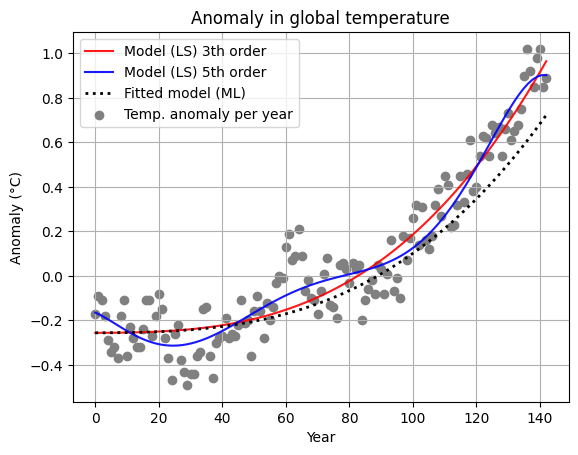

In [ ]:
#Hago el mismo procedimiento que antes, solamente cambiando al modelo de orden 3
#Y actualizando los parámetros iniciales por los obtenidos con LS para el nuevo modelo
nll = lambda *args: -log_likelihood(*args)
initial = np.array([w_test[0], w_test[1], w_test[2],w_test[3], np.log(f_true)])
soln = minimize(nll, initial, args=(X, Y, yerr))
w0ml, w1ml, w2ml, w3ml, log_f_ml = soln.x

print("Maximum likelihood estimates:")
print("w0 = {0:.6f}".format(w0ml))
print("w1 = {0:.6f}".format(w1ml))
print("w2 = {0:.6f}".format(w2ml))
print("w3 = {0:.6f}".format(w3ml))
print("f = {0:.2f}".format(np.exp(log_f_ml)))
#Imprimo el modelo anterior y el nuevo obtenidos por LS, y también el modelo de ML,
#Además de mostrar también la dispersión de datos
plt.plot(x0, w_test[0]+w_test[1]*x0+w_test[2]*x0**2+w_test[3]*x0**3, color = 'red', label="Model (LS) 3th order", linewidth = '1.5', alpha = 0.9) #Modelo nuevo LS
plt.plot(x0, y_p, color = 'blue', label="Model (LS) 5th order", linewidth = '1.5', alpha = 0.9) #Modelo viejo LS
plt.plot(x0, w0ml + w1ml*x0 + w2ml*x0**2 + w3ml*x0**3, ":k", label="Fitted model (ML)", linewidth = 2) #Modelo nuevo ML
plt.scatter(X, Y, color = 'gray', label = 'Temp. anomaly per year') #Dispersión de datos
plt.xlabel("Year")
plt.ylabel("Anomaly (°C)")
plt.title('Anomaly in global temperature')
plt.grid()
plt.legend()
plt.show()

Finalmente, haré el análisis de MCMC

**MCMC**

In [ ]:
#Defino la función de ln(p) con el modelo nuevo
def log_prior(theta):
    w0, w1, w2, w3, log_f = theta
    if -1.0 < w0 < 1 and 0.0 < w1 < 1.0 and -1.0 < w2 < 1.0 and -1 < w3 < 1 and -5 < log_f_ml < 5 :
        return 0.0
    return -np.inf

In [ ]:
#Defino la función ln(P) que incluye la función ya definida ln(Likelihood)
def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

In [ ]:
#Importo la paquetería emcee
import emcee
#Los valores iniciales de los walkers serán los parámetros obtenidos con ML
pos = soln.x + 1e-4 * np.random.randn(32, 5)
nwalkers, ndim = pos.shape
#Utilizamos la función EnsembleSampler, la cual crea un conjunto de muestras
#con los parámetros de entrada que son el número de caminantes, la dimensión
#del espacio de parámetros y la función ln(P) que nos devuelve el posterior
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(X, Y, yerr)
)
sampler.run_mcmc(pos, 5000, progress=True); #finalmente usando run_mcmc inicializamos el proceso,
# dándole el número de iteraciones y el estado inicial (los parámetros iniciales)

100%|██████████| 5000/5000 [00:18<00:00, 265.59it/s]


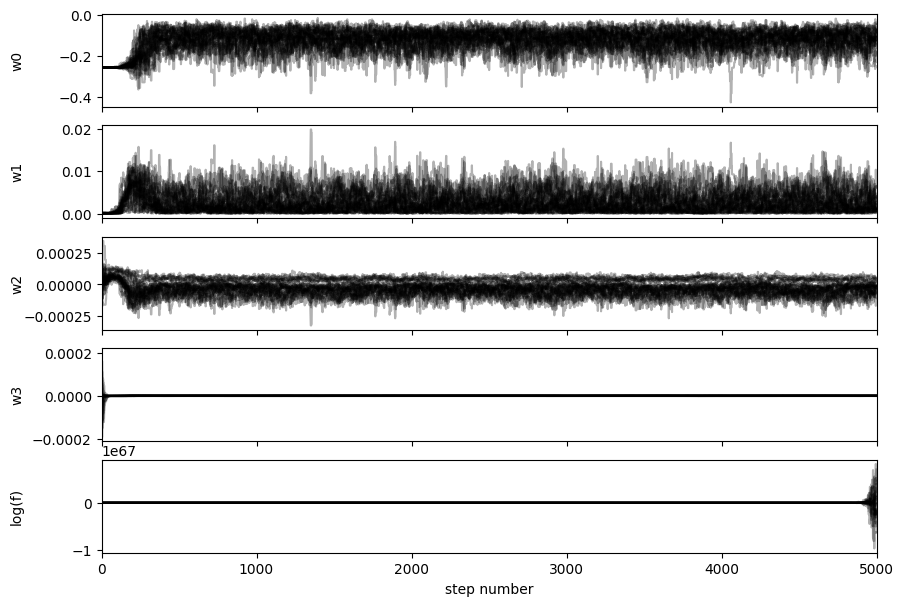

In [ ]:
#Usando la funicón get_chain podemos obtener toda la "historia" de los walkers
#La cual podemos graficar como una gráfica de tipo parámetro vs tiempo(en términos de iteraciones)
fig, axes = plt.subplots(5, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["w0", "w1",'w2','w3', "log(f)"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [ ]:
#Con la función get_autocorr_time podemos saber la autocorrelación de los datos
#la cuál básicamente es que en cierto espacio de las posiciones de los parámetros
#los parámetros se parecen entre sí todos lo parámetros en esa zona o dicho de
#otra manera, en cuántos pasos la cadena se "olvidó" de dónde empezó.
tau = sampler.get_autocorr_time()
print(tau)

AutocorrError: ignored

In [ ]:
#Con la siguiente línea de código descartamos los primeros 100 pasos (donde la cadena)
#ya se "olvidó" de dónde comenzó, para crear una muestra plana
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

(10432, 5)


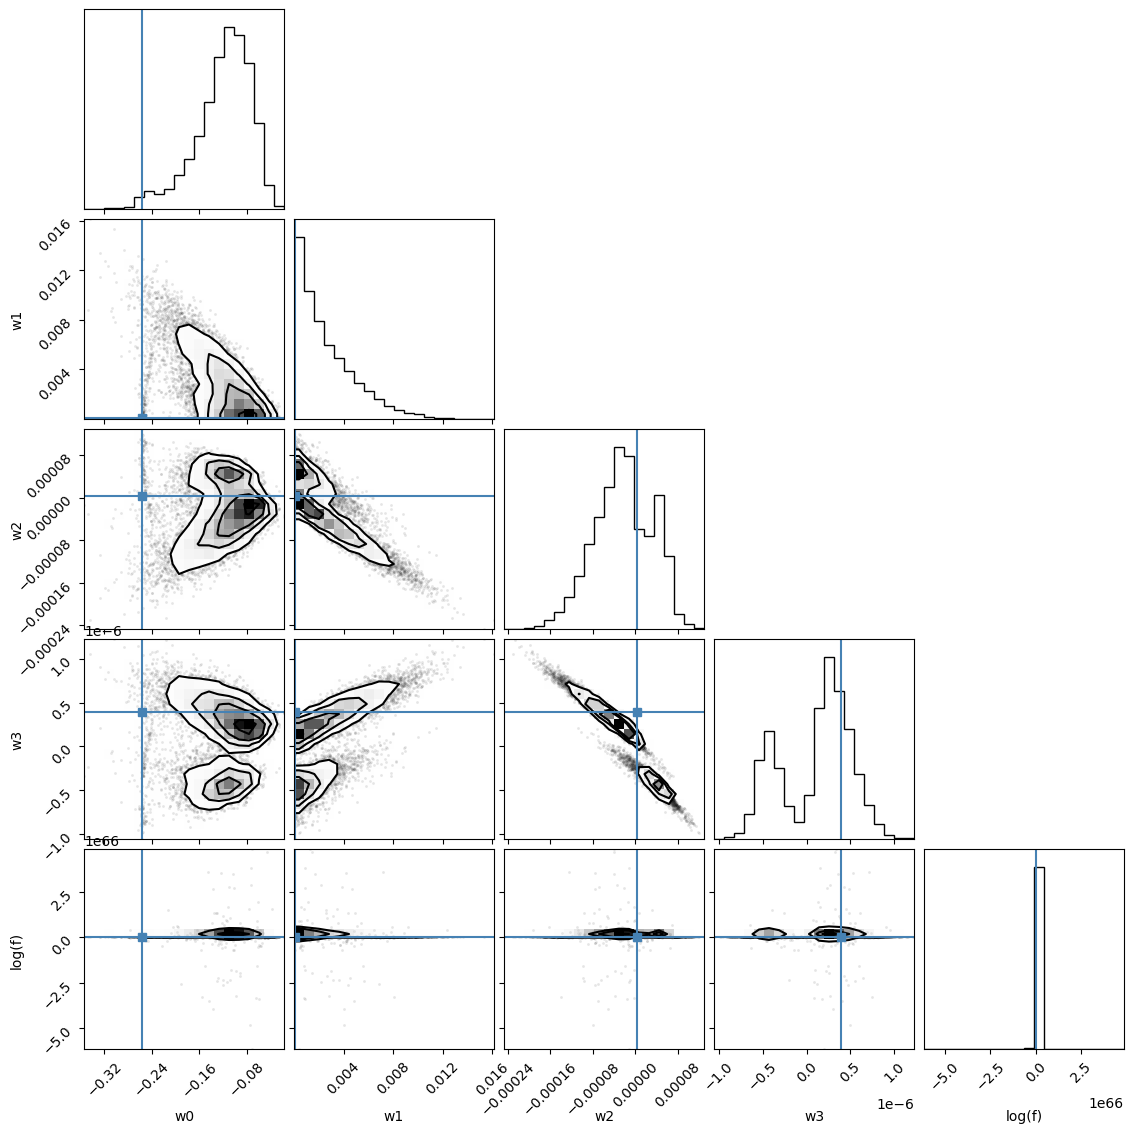

In [ ]:
#Finalmente muestro los resultados de MCMC usando corner plots de corner.py
import corner

fig = corner.corner(
    flat_samples, labels=labels, truths=[w_test[0], w_test[1],w_test[2],w_test[3], np.log(f_true)]
);

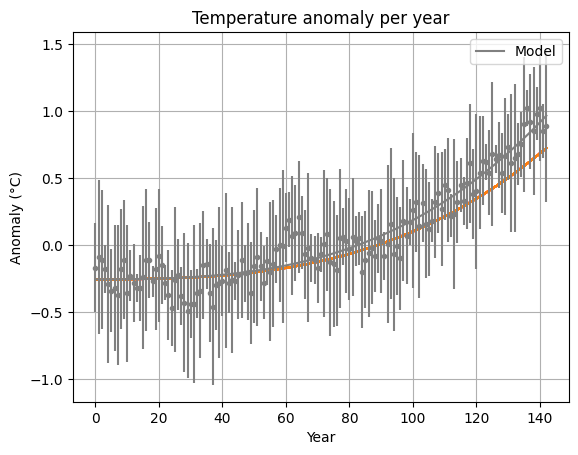

In [ ]:
#Grafico 100 muestras de la cadena para comparar con los datos reales
inds = np.random.randint(len(flat_samples), size=100)
for ind in inds:
    sample = flat_samples[ind]
    plt.plot(x0,w0ml + w1ml*x0 + w2ml*x0**2 + w3ml*x0**3, 'C1' , alpha=0.1)
plt.errorbar(X-min(X), Y, yerr=yerr, fmt=".",color = 'gray' , capsize=0)
plt.plot(x0, w_test[0]+w_test[1]*x0+w_test[2]*x0**2+w_test[3]*x0**3, color = "gray", label="Model")
plt.legend()
plt.xlabel("Year")
plt.ylabel("Anomaly (°C)")
plt.title('Temperature anomaly per year')
plt.grid();

**Referencias**

Dan Foreman-Mackey & contributors. (ND). *Fitting a model to a data*. Recuperado el 27 de octubre de 2023 de https://emcee.readthedocs.io/en/stable/tutorials/line/

The SciPy community. (ND). *Scipy*. Recuperado el 29 de octubre de 2023 de https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html

Dan Foreman-Mackey & contributors. (ND). *The Ensemble Sampler*. Recuperado el 27 de octubre de 2023 de https://emcee.readthedocs.io/en/stable/user/sampler/

Dan Foreman-Mackey. (ND). *Corner.py*. Recuperado el 29 de octubre de 2023 de https://corner.readthedocs.io/en/latest/

https://es.wikipedia.org/wiki/Autocorrelaci%C3%B3n#:~:text=La%20autocorrelaci%C3%B3n%20o%20dependencia%20secuencial,el%20hecho%20de%20estar%20cerca.

